# 🏃 Player Kinematics — Cinemática de Jugadores

Pipeline completo para detectar y trackear jugadores de fútbol frame a frame,
calculando posición, velocidad y distancia recorrida. Exporta `tracking_data.csv` y `player_summary.csv`.

**Características principales:**
- Detección con **YOLOv8** (clase COCO `person`).
- Tracking multi-objeto con **ByteTrack** — mantiene IDs consistentes aunque el jugador se ocluya brevemente.
- Conversión píxel → metro mediante **homografía** (o escala lineal como fallback).
- Cálculo de **velocidad suavizada** y **distancia acumulada** por jugador.
- Resumen estadístico y visualizaciones al final del bucle.

## 1 · Instalación de dependencias

In [1]:
!pip install ultralytics supervision opencv-python-headless pandas matplotlib seaborn -q

## 2 · Imports

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pathlib import Path
from collections import defaultdict
from ultralytics import YOLO
import supervision as sv

## 3 · Configuración

> **Ajusta las rutas y parámetros antes de ejecutar.**

In [ ]:
# ─── Rutas ────────────────────────────────────────────────────────────────────
INPUT_VIDEO_PATH  = r'C:\ruta\a\proyecto\field_vision_sant\videos\input\0bfacc_0.mp4'
OUTPUT_VIDEO_PATH = r'C:\ruta\a\proyecto\field_vision_sant\videos\output\output_0bfacc_0.mp4'
OUTPUT_CSV_PATH         = 'tracking_data.csv'
OUTPUT_SUMMARY_CSV_PATH = 'player_summary.csv'

# ─── Modelo ───────────────────────────────────────────────────────────────────
MODEL_NAME      = 'yolov8n.pt'  # yolov8s.pt o yolov8m.pt para más precisión
PLAYER_CLASS_ID = 0             # COCO: 'person' = 0
CONF_THRESHOLD  = 0.4           # confianza mínima para considerar una detección

# ─── Calibración píxel → metro ────────────────────────────────────────────────
# Mide una distancia conocida en el campo (p.ej. el área de penalti = 40.32 m)
# y cuenta cuántos píxeles ocupa; luego:
#   PIXELS_PER_METER = píxeles_de_esa_distancia / metros_reales
# Sólo se usa si no se define la homografía en la Sección 6.
PIXELS_PER_METER = 10.0  # ← AJUSTA según tu cámara / zoom

# ─── Velocidad ────────────────────────────────────────────────────────────────
SPEED_SMOOTHING_WINDOW = 5   # número de frames para promediar la velocidad

# ─── ByteTrack ────────────────────────────────────────────────────────────────
TRACK_THRESH = 0.4   # confianza mínima para iniciar un track nuevo
TRACK_BUFFER = 30    # frames que se mantiene vivo un track sin detección
MATCH_THRESH = 0.8   # umbral de IoU para asociar detección con track existente

# ─── Anotación visual ─────────────────────────────────────────────────────────
TRAIL_LENGTH = 20    # frames de estela por jugador en el vídeo de salida

print('✅ Configuración cargada')

✅ Configuración cargada


## 4 · Info del vídeo

In [4]:
def get_video_info(path: str) -> dict:
    """Devuelve metadatos básicos de un fichero de vídeo."""
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise FileNotFoundError(
            f'❌ No se pudo abrir el vídeo.\n'
            f'   Ruta probada: {path}\n'
            f'   Verifica que existe y que el codec es compatible.'
        )
    fps          = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if fps == 0:
        raise ValueError(
            f'❌ El vídeo se abrió pero FPS = 0.\n'
            f'   El fichero puede estar corrupto o usar un codec no soportado.\n'
            f'   Ruta: {path}'
        )
    info = {
        'fps':          fps,
        'width':        int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        'height':       int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        'total_frames': total_frames,
        'duration_s':   round(total_frames / fps, 2),
    }
    cap.release()
    return info


# ── Verificación rápida de ruta ───────────────────────────────────────────────
p = Path(INPUT_VIDEO_PATH)
print(f'Ruta:    {p.resolve()}')
print(f'Existe:  {p.exists()}')
if p.exists():
    print(f'Tamaño:  {p.stat().st_size / 1e6:.2f} MB')

video_info = get_video_info(INPUT_VIDEO_PATH)
FPS = video_info['fps']
W   = video_info['width']
H   = video_info['height']

print('\n📹 Info del vídeo:')
for k, v in video_info.items():
    print(f'   {k}: {v}')

Ruta:    C:\Users\lurib\OneDrive\Escritorio\field_vision_sant\videos\input\0bfacc_0.mp4
Existe:  True
Tamaño:  19.88 MB

📹 Info del vídeo:
   fps: 25.0
   width: 1920
   height: 1080
   total_frames: 750
   duration_s: 30.0


## 5 · Diagnóstico: clases detectadas en el primer frame

Útil para confirmar que el modelo detecta jugadores correctamente y revisar
si hay falsos positivos frecuentes (p.ej. árbitros, publicidad, etc.).

In [5]:
model = YOLO(MODEL_NAME)

cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
ret, first_frame = cap.read()
cap.release()

# Inferencia sin filtro de clase para ver todo lo que detecta el modelo
results = model(first_frame, verbose=False, conf=0.25)[0]

print('Todas las detecciones en el primer frame (conf > 0.25):')
for box, cls, conf in zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf):
    name = model.names[int(cls)]
    print(f'  clase {int(cls):>3} ({name:<22})  conf: {conf:.2f}')

print(f'\n👤 Total de personas detectadas: '
      f'{sum(1 for c in results.boxes.cls if int(c) == PLAYER_CLASS_ID)}')

Todas las detecciones en el primer frame (conf > 0.25):
  clase   0 (person                )  conf: 0.74
  clase   0 (person                )  conf: 0.68
  clase   0 (person                )  conf: 0.67
  clase   0 (person                )  conf: 0.64
  clase   0 (person                )  conf: 0.62
  clase   7 (truck                 )  conf: 0.56
  clase   0 (person                )  conf: 0.56
  clase   0 (person                )  conf: 0.55
  clase   0 (person                )  conf: 0.55
  clase   0 (person                )  conf: 0.54
  clase   0 (person                )  conf: 0.53
  clase   0 (person                )  conf: 0.51
  clase   0 (person                )  conf: 0.51
  clase   0 (person                )  conf: 0.51
  clase   0 (person                )  conf: 0.50
  clase   0 (person                )  conf: 0.47
  clase   0 (person                )  conf: 0.47
  clase   0 (person                )  conf: 0.46
  clase   0 (person                )  conf: 0.44
  clase   0 (

## 6 · Calibración: homografía píxel → metro

### ¿Por qué no basta con `PIXELS_PER_METER`?

La conversión lineal asume que la cámara es cenital y que un píxel siempre
equivale a la misma distancia real en cualquier punto del frame.
En una retransmisión real esto **nunca es cierto**: los jugadores al fondo
del campo aparecen más pequeños que los del frente, por lo que la misma
distancia en píxeles significa distancias reales muy distintas.

La **homografía** corrige esto: mapea 4 puntos conocidos del campo
(p.ej. las 4 esquinas del área de penalti, cuyas dimensiones reales conocemos)
a sus posiciones en píxeles, y OpenCV calcula la matriz de transformación
que convierte correctamente cualquier coordenada de píxel a metros reales.

```
pixel_distance = √((cx2-cx1)² + (cy2-cy1)²)
real_distance  = pixel_distance / PIXELS_PER_METER   ← sin homografía (aproximado)

real_point = H · pixel_point                         ← con homografía (correcto)
```

### Opción A — Homografía interactiva (recomendada)

Ejecuta las celdas 6a y 6b para hacer clic en el frame y calcular `H_MATRIX`.

### Opción B — Escala lineal (fallback)

Ejecuta la celda 6c para usar `PIXELS_PER_METER` directamente sin homografía.

### 6a · Puntos de referencia del campo (metros reales)

In [6]:
# ─── Coordenadas reales de 4 marcas conocidas del campo (en metros) ───────────
# Origen (0, 0) = esquina superior-izquierda del campo.
# Campo estándar de fútbol: 105 m largo × 68 m ancho.
#
# Por defecto: las 4 esquinas del área de penalti IZQUIERDA.
#   superior-izq  = (0,    13.84)
#   superior-dcha = (16.5, 13.84)
#   inferior-dcha = (16.5, 54.16)
#   inferior-izq  = (0,    54.16)
#
# Cambia estos puntos por las marcas que sean claramente visibles en tu frame.
# Los puntos deben estar en el MISMO ORDEN en que harás clic en la celda 6b.

PITCH_POINTS_METERS = np.float32([
    [0,    13.84],   # esquina superior-izquierda del área
    [16.5, 13.84],   # esquina superior-derecha del área
    [16.5, 54.16],   # esquina inferior-derecha del área
    [0,    54.16],   # esquina inferior-izquierda del área
])

print('✅ Puntos de referencia del campo definidos (metros):')
for i, pt in enumerate(PITCH_POINTS_METERS):
    print(f'   Punto {i+1}: ({pt[0]:.2f} m,  {pt[1]:.2f} m)')

✅ Puntos de referencia del campo definidos (metros):
   Punto 1: (0.00 m,  13.84 m)
   Punto 2: (16.50 m,  13.84 m)
   Punto 3: (16.50 m,  54.16 m)
   Punto 4: (0.00 m,  54.16 m)


### 6b · Calibración interactiva por clic

> **¿Por qué el gráfico no responde a los clics?**
>
> En Jupyter el backend por defecto (`inline`) renderiza los gráficos como
> imágenes estáticas (PNG), por lo que los eventos de ratón **nunca llegan a
> matplotlib**. Para habilitar la interactividad hay que cambiar el backend
> **antes** de importar matplotlib.
>
> **Elige UNA opción según tu entorno:**
>
> | Entorno | Magic | Requisito |
> |---|---|---|
> | JupyterLab / VS Code / Notebook ≥7 | `%matplotlib widget` | `pip install ipympl` |
> | Jupyter Notebook clásico (ventana externa) | `%matplotlib tk` | Tkinter (incluido en Python) |
>
> **Pasos:**
> 1. Ejecuta la celda de instalación de `ipympl` justo debajo.
> 2. **Reinicia el kernel** (Kernel → Restart).
> 3. Vuelve a ejecutar todas las celdas desde la Sección 1 hasta aquí.
> 4. La figura mostrará un widget interactivo donde podrás hacer clic.

In [7]:
# Instala ipympl (solo necesario la primera vez si usas %matplotlib widget)
!pip install ipympl -q
print('✅ ipympl instalado.')
print('   → REINICIA EL KERNEL y ejecuta de nuevo desde la Sección 1.')

✅ ipympl instalado.
   → REINICIA EL KERNEL y ejecuta de nuevo desde la Sección 1.


In [8]:
# ──────────────────────────────────────────────────────────────────────────────
# PASO 1: activa el backend interactivo (descomenta UNA de las dos líneas).
# Esta magic DEBE ejecutarse antes de cualquier import de matplotlib.
# ──────────────────────────────────────────────────────────────────────────────
#%matplotlib widget   # ← Opción A: JupyterLab / VS Code / Notebook ≥7 (requiere ipympl)
%matplotlib tk     # ← Opción B: Notebook clásico, abre una ventana externa

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ── Carga el primer frame ─────────────────────────────────────────────────────
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
ret, first_frame = cap.read()
cap.release()
if not ret:
    raise RuntimeError('❌ No se pudo leer el primer frame. Verifica INPUT_VIDEO_PATH.')

frame_rgb = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)

# ── Estado de los clics ───────────────────────────────────────────────────────
clicked_pixels = []
N_POINTS       = len(PITCH_POINTS_METERS)

POINT_LABELS = [
    'esquina superior-izquierda del área',
    'esquina superior-derecha del área',
    'esquina inferior-derecha del área',
    'esquina inferior-izquierda del área',
]
COLORES = ['red', 'lime', 'deepskyblue', 'yellow']


def on_click(event):
    """Callback de clic: registra el punto y calcula la homografía al completar."""
    if event.inaxes != ax:
        return
    if event.button != 1:   # solo botón izquierdo
        return
    if len(clicked_pixels) >= N_POINTS:
        print('⚠️  Ya tienes todos los puntos. Reinicia la celda para repetir.')
        return

    x, y = event.xdata, event.ydata
    idx  = len(clicked_pixels)
    clicked_pixels.append([x, y])

    # Dibuja marcador y etiqueta sobre el frame en tiempo real
    ax.plot(x, y, 'o', color=COLORES[idx], markersize=12,
            markeredgecolor='white', markeredgewidth=1.5, zorder=5)
    ax.annotate(
        f'  {idx+1}. {POINT_LABELS[idx]}',
        (x, y), color=COLORES[idx],
        fontsize=9, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.2', fc='black', alpha=0.7),
    )
    fig.canvas.draw()
    print(f'  ✔ Punto {idx+1}/{N_POINTS} — {POINT_LABELS[idx]}  →  píxel ({x:.1f}, {y:.1f})')

    if len(clicked_pixels) == N_POINTS:
        _compute_homography()


def _compute_homography():
    """Calcula H_MATRIX en cuanto se tienen los 4 puntos."""
    global H_MATRIX, H_MATRIX_INV

    src = np.float32(clicked_pixels)   # coordenadas en píxeles
    dst = PITCH_POINTS_METERS          # coordenadas reales en metros

    H_MATRIX,     _ = cv2.findHomography(src, dst)
    H_MATRIX_INV, _ = cv2.findHomography(dst, src)

    print('\n✅ Matriz de homografía calculada.')
    print('   Verificación de reproyección (error ideal < 0.5 m):')
    for i, (px, real) in enumerate(zip(clicked_pixels, PITCH_POINTS_METERS)):
        pt_h     = np.float32([[px]])
        reprojed = cv2.perspectiveTransform(pt_h[np.newaxis], H_MATRIX)[0][0]
        err      = np.linalg.norm(reprojed - real)
        px_int   = [int(round(v)) for v in px]
        print(f'   Punto {i+1}: píxel {px_int} → {reprojed.round(2)} m  '
              f'(esperado {real.tolist()}, error {err:.3f} m)')

    ax.set_title('✅ Homografía lista — errores de reproyección en consola',
                 color='limegreen', fontsize=11)
    fig.canvas.draw()


# ── Figura interactiva ────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))
ax.imshow(frame_rgb)
ax.set_title(
    f'Haz clic en {N_POINTS} puntos en este orden:\n' +
    '  '.join([f'{i+1}. {POINT_LABELS[i]}' for i in range(N_POINTS)]),
    fontsize=10,
)

patches = [
    mpatches.Patch(color=COLORES[i], label=f'{i+1}. {POINT_LABELS[i]}')
    for i in range(N_POINTS)
]
ax.legend(handles=patches, loc='lower right', fontsize=8,
          facecolor='black', labelcolor='white')

fig.canvas.mpl_connect('button_press_event', on_click)
plt.tight_layout()
plt.show()

print(f'\n👆 Haz clic en los {N_POINTS} puntos del frame en el orden indicado.')

UsageError: unrecognized arguments: # ← Opción B: Notebook clásico, abre una ventana externa


### 6c · Fallback: escala lineal sin homografía

Ejecuta esta celda **en lugar de 6b** si no puedes identificar los 4 puntos
de referencia en el frame, o si prefieres una aproximación rápida.

In [9]:
# Conversión directa píxel → metro sin corrección de perspectiva.
# Las distancias serán aproximadas (mayor error en los extremos del frame).
H_MATRIX = None

print('✅ Modo sin homografía activado')
print(f'   Usando PIXELS_PER_METER = {PIXELS_PER_METER}')
print('   ⚠️  Las distancias serán aproximadas — ajusta PIXELS_PER_METER en la Sección 3')

✅ Modo sin homografía activado
   Usando PIXELS_PER_METER = 10.0
   ⚠️  Las distancias serán aproximadas — ajusta PIXELS_PER_METER en la Sección 3


## 7 · Helper de conversión píxel → metro

In [10]:
def pixel_to_meters(cx_px: float, cy_px: float,
                    H: np.ndarray = None) -> tuple:
    """
    Convierte coordenadas de píxel a metros reales en el campo.

    Si H (matriz de homografía 3×3) está disponible, aplica la transformación
    de perspectiva. En caso contrario usa escala lineal con PIXELS_PER_METER.

    Parámetros
    ----------
    cx_px, cy_px : coordenadas del punto en píxeles.
    H            : matriz de homografía obtenida en la Sección 6 (o None).

    Devuelve
    --------
    (mx, my) : coordenadas en metros, redondeadas a 3 decimales.
    """
    if H is not None:
        pt  = np.float32([[[cx_px, cy_px]]])
        out = cv2.perspectiveTransform(pt, H)[0][0]
        return round(float(out[0]), 3), round(float(out[1]), 3)
    return round(cx_px / PIXELS_PER_METER, 3), round(cy_px / PIXELS_PER_METER, 3)


print('✅ pixel_to_meters() listo')
print(f'   Modo: {"homografía" if H_MATRIX is not None else f"lineal ({PIXELS_PER_METER} px/m)"}')

✅ pixel_to_meters() listo
   Modo: lineal (10.0 px/m)


## 8 · PlayerTracker — clase principal

Mantiene el historial de posiciones por jugador (identificado por su `tracker_id` de ByteTrack)
y calcula velocidad suavizada y distancia acumulada.

In [11]:
class PlayerTracker:
    """
    Trackea jugadores y computa velocidad / distancia usando
    coordenadas reales en metros (vía homografía o escala lineal).

    Atributos internos
    ------------------
    positions : dict  tid → [(frame, mx, my)]   historial de posiciones
    speeds    : dict  tid → [speed_kmh]          historial de velocidades instantáneas
    distances : dict  tid → float                distancia acumulada en metros
    """

    def __init__(self, fps: float, smoothing_window: int = 5):
        """
        Parámetros
        ----------
        fps              : fotogramas por segundo del vídeo.
        smoothing_window : número de frames para promediar la velocidad
                           (reduce el ruido frame a frame).
        """
        self.fps = fps
        self.sw  = smoothing_window
        self.positions = defaultdict(list)    # tid → [(frame, mx, my)]
        self.speeds    = defaultdict(list)    # tid → [speed_kmh]
        self.distances = defaultdict(float)   # tid → metros totales

    def update(self, track_ids: np.ndarray,
               boxes_xyxy: np.ndarray,
               frame_idx: int) -> None:
        """
        Actualiza el historial con las detecciones del frame actual.

        Usa el punto inferior-central de la bounding box (pie del jugador)
        como posición en el plano del campo, minimizando el error
        introducido por la perspectiva.

        Ignora desplazamientos > 10 m/frame (glitches de tracking).
        """
        for tid, box in zip(track_ids, boxes_xyxy):
            # Punto inferior-central de la caja → más cercano al plano del suelo
            cx = (box[0] + box[2]) / 2.0
            cy = float(box[3])   # borde inferior

            # Convertir a metros reales
            mx, my = pixel_to_meters(cx, cy, H_MATRIX)

            history = self.positions[tid]
            if history:
                pmx, pmy = history[-1][1], history[-1][2]
                dist_m   = np.sqrt((mx - pmx)**2 + (my - pmy)**2)

                if dist_m < 10.0:   # desplazamiento plausible
                    speed_kmh = dist_m * self.fps * 3.6
                    self.distances[tid] += dist_m
                    self.speeds[tid].append(speed_kmh)
                else:
                    # Mantiene la última velocidad conocida en lugar de un pico falso
                    last = self.speeds[tid][-1] if self.speeds[tid] else 0.0
                    self.speeds[tid].append(last)
            else:
                self.speeds[tid].append(0.0)   # primer frame: velocidad 0

            history.append((frame_idx, mx, my))

    def get_current_speed(self, tid: int) -> float:
        """
        Devuelve la velocidad media suavizada (km/h) de las últimas
        `smoothing_window` frames del jugador `tid`.
        """
        s = self.speeds.get(tid, [0.0])
        return float(np.mean(s[-self.sw:]))

    def get_total_distance(self, tid: int) -> float:
        """Devuelve la distancia acumulada en metros del jugador `tid`."""
        return self.distances.get(tid, 0.0)

    def summary(self) -> pd.DataFrame:
        """
        Genera un DataFrame resumen por jugador con:
          player_id, frames_tracked, total_distance_m,
          avg_speed_kmh, max_speed_kmh, min_speed_kmh, time_on_pitch_s.
        """
        rows = []
        for tid in self.positions:
            s = self.speeds[tid]
            rows.append({
                'player_id':        tid,
                'frames_tracked':   len(self.positions[tid]),
                'total_distance_m': round(self.distances[tid], 2),
                'avg_speed_kmh':    round(float(np.mean(s)) if s else 0.0, 2),
                'max_speed_kmh':    round(float(np.max(s))  if s else 0.0, 2),
                'min_speed_kmh':    round(float(np.min(s))  if s else 0.0, 2),
                'time_on_pitch_s':  round(len(self.positions[tid]) / self.fps, 1),
            })
        return pd.DataFrame(rows).sort_values('player_id').reset_index(drop=True)


print('✅ PlayerTracker definido')

✅ PlayerTracker definido


## 9 · Anotación visual

In [12]:
from collections import defaultdict, deque

# Paleta de colores cíclica para distinguir jugadores
PALETTE = plt.cm.get_cmap('tab20').colors

# Historial de posiciones para dibujar la estela de cada jugador
player_trails: dict[int, deque] = defaultdict(lambda: deque(maxlen=TRAIL_LENGTH))


def player_colour(tid: int) -> tuple:
    """Devuelve el color BGR asignado al jugador `tid` de forma consistente."""
    r, g, b = [int(c * 255) for c in PALETTE[tid % len(PALETTE)][:3]]
    return (b, g, r)   # OpenCV usa BGR


def annotate_frame(frame: np.ndarray,
                   track_ids: np.ndarray,
                   boxes: np.ndarray,
                   tracker: PlayerTracker) -> np.ndarray:
    """
    Dibuja sobre el frame:
      - Bounding box con color único por jugador.
      - Etiqueta con ID, velocidad actual y distancia acumulada.
      - Estela de las últimas posiciones (punto inferior-central).
    """
    out = frame.copy()

    for tid, box in zip(track_ids, boxes):
        tid = int(tid)
        x1, y1, x2, y2 = map(int, box)
        col   = player_colour(tid)
        speed = tracker.get_current_speed(tid)
        dist  = tracker.get_total_distance(tid)

        # ── Estela ──────────────────────────────────────────────────────
        foot_x = (x1 + x2) // 2
        foot_y = y2
        player_trails[tid].append((foot_x, foot_y))
        trail = player_trails[tid]
        for i in range(1, len(trail)):
            alpha     = i / len(trail)
            t_col     = tuple(int(c * alpha) for c in col)
            thickness = max(1, int(3 * alpha))
            cv2.line(out, trail[i-1], trail[i], t_col, thickness, cv2.LINE_AA)

        # ── Caja ────────────────────────────────────────────────────────
        cv2.rectangle(out, (x1, y1), (x2, y2), col, 2)

        # ── Etiqueta ────────────────────────────────────────────────────
        label = f'P{tid}  {speed:.1f}km/h  {dist:.1f}m'
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.55, 1)
        cv2.rectangle(out, (x1, y1 - th - 8), (x1 + tw + 4, y1), col, -1)
        cv2.putText(out, label, (x1 + 2, y1 - 4),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 255, 255), 1, cv2.LINE_AA)

    return out


print('✅ annotate_frame() definida')

✅ annotate_frame() definida


## 10 · Bucle principal de tracking

In [13]:
# ── Inicialización ────────────────────────────────────────────────────────────
model        = YOLO(MODEL_NAME)
tracker      = PlayerTracker(FPS, SPEED_SMOOTHING_WINDOW)
byte_tracker = sv.ByteTrack(
    track_activation_threshold = TRACK_THRESH,
    lost_track_buffer          = TRACK_BUFFER,
    minimum_matching_threshold = MATCH_THRESH,
    frame_rate                 = int(FPS),
)

cap    = cv2.VideoCapture(INPUT_VIDEO_PATH)
writer = cv2.VideoWriter(
    OUTPUT_VIDEO_PATH,
    cv2.VideoWriter_fourcc(*'mp4v'),
    FPS, (W, H)
)

frame_records = []   # una fila por jugador por frame
frame_idx     = 0
n_players_total = 0

print('🔄 Procesando vídeo…')

# ── Bucle frame a frame ───────────────────────────────────────────────────────
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # ── Inferencia YOLO ───────────────────────────────────────────────────
    results = model(
        frame,
        classes = [PLAYER_CLASS_ID],   # sólo detecciones de personas
        conf    = CONF_THRESHOLD,
        verbose = False,
    )[0]

    detections = sv.Detections.from_ultralytics(results)

    # ── ByteTrack: asigna y mantiene IDs entre frames ─────────────────────
    tracked = byte_tracker.update_with_detections(detections)

    if len(tracked) > 0:
        tids  = tracked.tracker_id
        boxes = tracked.xyxy

        # Actualiza velocidades y distancias en PlayerTracker
        tracker.update(tids, boxes, frame_idx)

        ts = frame_idx / FPS

        # Guarda un registro por jugador en este frame
        for tid, box in zip(tids, boxes):
            cx = (box[0] + box[2]) / 2
            cy = float(box[3])   # borde inferior = pie del jugador
            mx, my = pixel_to_meters(cx, cy, H_MATRIX)
            frame_records.append({
                'frame':       frame_idx,
                'timestamp_s': round(ts, 3),
                'player_id':   int(tid),
                'cx_px':       round(cx, 1),
                'cy_px':       round(cy, 1),
                'mx':          round(mx, 3),
                'my':          round(my, 3),
                'speed_kmh':   round(tracker.get_current_speed(int(tid)), 2),
                'distance_m':  round(tracker.get_total_distance(int(tid)), 2),
            })

        n_players_total += len(tids)
        annotated = annotate_frame(frame, tids, boxes, tracker)
    else:
        annotated = frame

    writer.write(annotated)

    # Progreso cada 100 frames
    if frame_idx % 100 == 0:
        total = video_info['total_frames']
        pct   = frame_idx / total * 100
        n_ids = len(tracker.positions)
        print(f'   Frame {frame_idx}/{total} ({pct:.0f}%)  '
              f'jugadores únicos hasta ahora: {n_ids}')

    frame_idx += 1

cap.release()
writer.release()

print(f'\n✅ Procesados {frame_idx} frames')
print(f'   Jugadores únicos detectados: {len(tracker.positions)}')
print(f'   Registros frame×jugador:     {len(frame_records)}')
print(f'   Vídeo guardado en:           {OUTPUT_VIDEO_PATH}')

🔄 Procesando vídeo…
   Frame 0/750 (0%)  jugadores únicos hasta ahora: 13
   Frame 100/750 (13%)  jugadores únicos hasta ahora: 39
   Frame 200/750 (27%)  jugadores únicos hasta ahora: 64
   Frame 300/750 (40%)  jugadores únicos hasta ahora: 85
   Frame 400/750 (53%)  jugadores únicos hasta ahora: 109
   Frame 500/750 (67%)  jugadores únicos hasta ahora: 122
   Frame 600/750 (80%)  jugadores únicos hasta ahora: 135
   Frame 700/750 (93%)  jugadores únicos hasta ahora: 152

✅ Procesados 750 frames
   Jugadores únicos detectados: 167
   Registros frame×jugador:     8046
   Vídeo guardado en:           C:\Users\lurib\OneDrive\Escritorio\field_vision_sant\videos\output\output_0bfacc_0.mp4


## 11 · Exportar CSVs

In [14]:
# ── tracking_data.csv — una fila por jugador por frame ────────────────────────
tracking_df = pd.DataFrame(frame_records)

# ── player_summary.csv — una fila por jugador (resumen estadístico) ───────────
summary_df = tracker.summary()

if tracking_df.empty:
    print('⚠️  tracking_df está vacío — no se detectó ningún jugador.')
    print('   Comprueba CONF_THRESHOLD y que PLAYER_CLASS_ID = 0 (person).')
else:
    # Reordenar columnas para legibilidad
    cols = ['frame', 'timestamp_s', 'player_id',
            'cx_px', 'cy_px', 'mx', 'my',
            'speed_kmh', 'distance_m']
    tracking_df = tracking_df[cols]

    tracking_df.to_csv(OUTPUT_CSV_PATH,         index=False)
    summary_df.to_csv( OUTPUT_SUMMARY_CSV_PATH, index=False)

    print('✅ CSVs exportados:')
    print(f'   {OUTPUT_CSV_PATH:<30} — {tracking_df.shape[0]} filas × {tracking_df.shape[1]} columnas')
    print(f'   {OUTPUT_SUMMARY_CSV_PATH:<30} — {summary_df.shape[0]} jugadores')
    print()
    print('Primeras filas de tracking_data.csv:')
    display(tracking_df.head())

✅ CSVs exportados:
   tracking_data.csv              — 8046 filas × 9 columnas
   player_summary.csv             — 167 jugadores

Primeras filas de tracking_data.csv:


,frame,timestamp_s,player_id,cx_px,cy_px,mx,my,speed_kmh,distance_m
0,0,0.0,1,822.700012,1009.0,82.274002,100.903,0.0,0.0
1,0,0.0,2,1161.300049,730.4,116.125999,73.036,0.0,0.0
2,0,0.0,3,390.399994,949.1,39.042000,94.911,0.0,0.0
3,0,0.0,4,1494.599976,479.5,149.460999,47.949,0.0,0.0
4,0,0.0,5,1096.500000,577.4,109.649002,57.741,0.0,0.0


## 12 · Resumen estadístico por jugador

In [15]:
if not summary_df.empty:
    print('📊 Resumen estadístico por jugador:')
    display(summary_df)

    print(f'\n🏆 Jugador más rápido:    P{summary_df.loc[summary_df.max_speed_kmh.idxmax(), "player_id"]}'
          f'  —  {summary_df.max_speed_kmh.max():.1f} km/h')
    print(f'🏃 Mayor distancia:       P{summary_df.loc[summary_df.total_distance_m.idxmax(), "player_id"]}'
          f'  —  {summary_df.total_distance_m.max():.1f} m')
    print(f'⏱️  Mayor tiempo en campo: P{summary_df.loc[summary_df.time_on_pitch_s.idxmax(), "player_id"]}'
          f'  —  {summary_df.time_on_pitch_s.max():.1f} s')

📊 Resumen estadístico por jugador:


,player_id,frames_tracked,total_distance_m,avg_speed_kmh,max_speed_kmh,min_speed_kmh,time_on_pitch_s
0,1,69,17.049999,22.24,79.28,0.0,2.8
1,2,90,29.350000,29.35,185.86,0.0,3.6
2,3,100,26.799999,24.12,179.69,0.0,4.0
3,4,17,8.790000,46.52,335.32,0.0,0.7
4,5,36,11.030000,27.57,131.87,0.0,1.4
...,...,...,...,...,...,...,...
162,185,6,2.460000,36.97,62.07,0.0,0.2
163,186,1,0.000000,0.00,0.00,0.0,0.0
164,187,8,1.380000,15.54,24.19,0.0,0.3
165,188,1,0.000000,0.00,0.00,0.0,0.0



🏆 Jugador más rápido:    P50  —  614.8 km/h
🏃 Mayor distancia:       P8  —  165.8 m
⏱️  Mayor tiempo en campo: P8  —  28.6 s


## 13 · Análisis y visualización

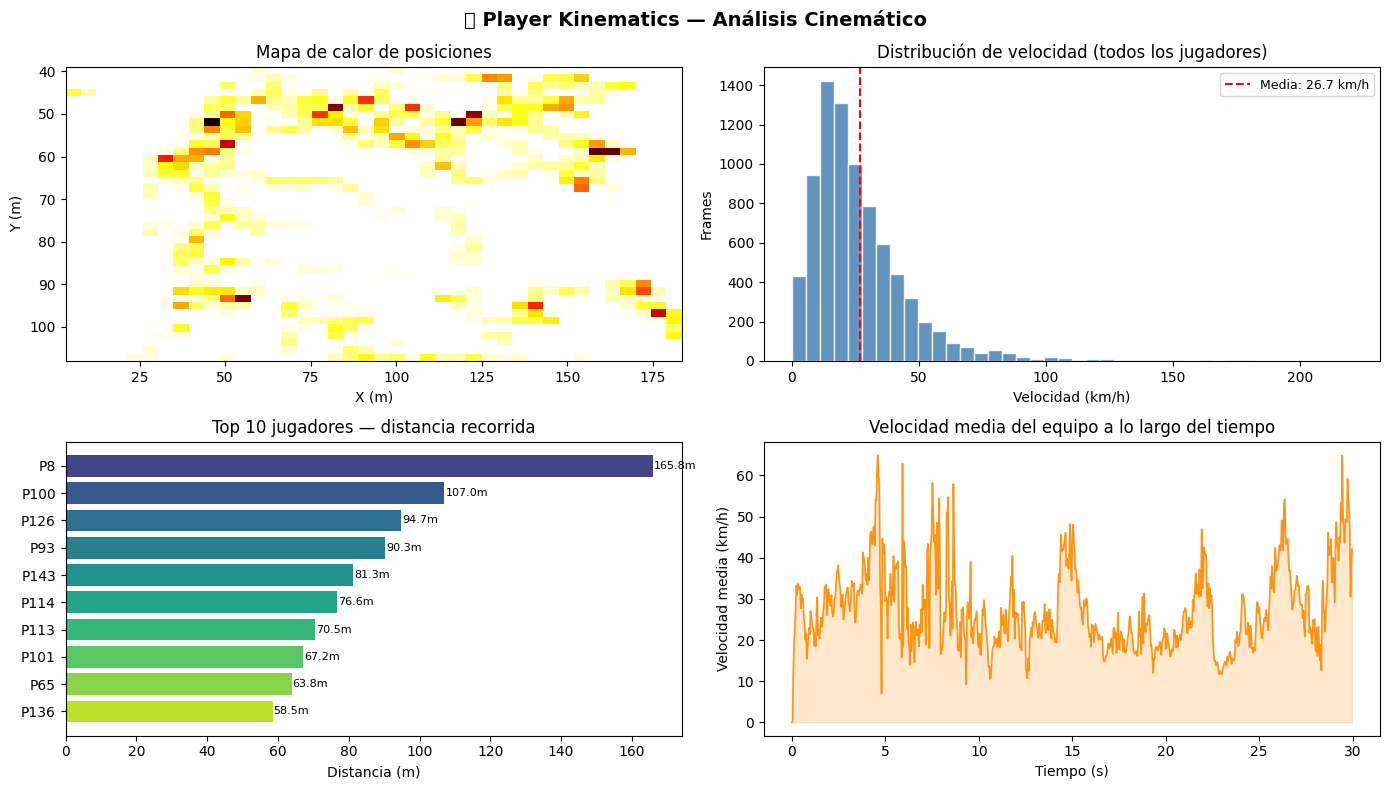

✅ Gráfico guardado en player_analysis.png


In [16]:
if not tracking_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle('🏃 Player Kinematics — Análisis Cinemático', fontsize=14, fontweight='bold')

    # ── Mapa de calor de posiciones en campo ──────────────────────────────
    ax = axes[0, 0]
    ax.hist2d(tracking_df['mx'], tracking_df['my'],
              bins=40, cmap='hot_r')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title('Mapa de calor de posiciones')
    ax.invert_yaxis()

    # ── Distribución de velocidades ───────────────────────────────────────
    ax = axes[0, 1]
    ax.hist(tracking_df['speed_kmh'], bins=40,
            color='steelblue', edgecolor='white', alpha=0.85)
    ax.axvline(tracking_df['speed_kmh'].mean(), color='red',
               linestyle='--', lw=1.5,
               label=f'Media: {tracking_df["speed_kmh"].mean():.1f} km/h')
    ax.set_xlabel('Velocidad (km/h)')
    ax.set_ylabel('Frames')
    ax.set_title('Distribución de velocidad (todos los jugadores)')
    ax.legend(fontsize=9)

    # ── Top 10 jugadores por distancia ────────────────────────────────────
    ax = axes[1, 0]
    top10 = summary_df.nlargest(10, 'total_distance_m')
    bars = ax.barh(
        [f'P{p}' for p in top10['player_id']],
        top10['total_distance_m'],
        color=plt.cm.viridis(np.linspace(0.2, 0.9, len(top10))),
    )
    ax.set_xlabel('Distancia (m)')
    ax.set_title('Top 10 jugadores — distancia recorrida')
    ax.invert_yaxis()
    for bar, val in zip(bars, top10['total_distance_m']):
        ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                f'{val:.1f}m', va='center', fontsize=8)

    # ── Velocidad media a lo largo del tiempo (todos los jugadores) ───────
    ax = axes[1, 1]
    mean_speed = tracking_df.groupby('timestamp_s')['speed_kmh'].mean()
    ax.plot(mean_speed.index, mean_speed.values,
            color='darkorange', lw=1.2, alpha=0.9)
    ax.fill_between(mean_speed.index, mean_speed.values,
                    alpha=0.2, color='darkorange')
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Velocidad media (km/h)')
    ax.set_title('Velocidad media del equipo a lo largo del tiempo')

    plt.tight_layout()
    plt.savefig('player_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('✅ Gráfico guardado en player_analysis.png')